In [61]:

## import modules
import warnings
warnings.filterwarnings('ignore')
import json
import re
import pandas as pd
import nltk
import math
from math import sqrt
import sklearn
import statsmodels.api as sm
from nltk.stem import WordNetLemmatizer 
from nltk import FreqDist
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
import numpy as np
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
from tqdm import tqdm
from sklearn import linear_model
import collections
from gensim.models import Word2Vec
from gensim.models import word2vec
import gensim
from gensim import corpora
import multiprocessing
import time
import inflect
from textblob import TextBlob
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer #该类会将文本中的词语转换为词频矩阵，矩阵元素a[i][j] 表示j词在i类文本下的词频
from sklearn.feature_extraction.text import TfidfTransformer
import spacy
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


## define stopwords
sr = stopwords.words('english')
p = inflect.engine()
wnl = WordNetLemmatizer() 
table = str.maketrans('', '', string.punctuation)

In [2]:
## read review data
data_train=pd.read_csv("review_train.csv")

In [75]:
## review processiong
review_train_clean = [[1]]*len(data_train)
for i in tqdm(range(len(data_train))):
    #Change n't into not
    x = re.sub(r'n\'t',' not',data_train.iloc[i]['text'])
    #Change not adj into not_adj
    x = re.sub(r'not ','not_',x)
    #Split into words
    x = word_tokenize(x)
    #Remove punctuation
    x = [w.translate(table) if not re.match(r'not_.*', w) else w for w in x]
    #Change numbers into words
    x = [p.number_to_words(w) if w.isdigit() else w  for w in x ]
    #Remove not alphabetic
    x = [w for w in x if w.isalpha() or re.match(r'not_.*',w)]
    #Convert to lower case
    x = [w.lower() for w in x]
    #Remove stop words
    x = [w for w in x if not w in sr]
    ## lemmatization
    x = [wnl.lemmatize(w) for w in x]
    review_train_clean[i] = x

100%|██████████| 35033/35033 [01:06<00:00, 524.81it/s]


# Method 1 ：行业featues挖掘

## 仅对所有reviews中的名词进行LDA主题建模，得到十个维度的关键词，从每个维度中挑选概率最大的作为features备选。

In [3]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()


In [4]:
# remove non alphabetic
reviews_all = data_train['text'].str.replace("[^a-zA-Z#]", " ")


# function to remove stopwords
stop_words = stopwords.words('english')
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words (length < 3)
reviews_all = reviews_all.apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews_all = [remove_stopwords(r.split()) for r in reviews_all]

# make entire text lowercase
reviews_all = [r.lower() for r in reviews_all]

In [5]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [6]:
#def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
def lemmatization(texts, tags='NOUN'): # filter nouns
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent)) 
             output.append([token.lemma_ for token in doc if token.pos_ == tags])
       return output

In [7]:
tokenized_reviews = pd.Series(reviews_all).apply(lambda x: x.split())

In [8]:
reviews_lem= lemmatization(tokenized_reviews)

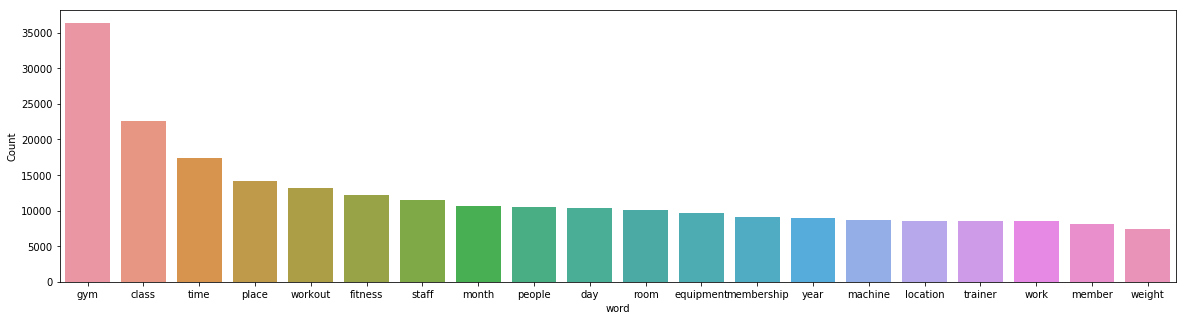

In [9]:
reviews_nouns = []
for i in range(len(reviews_lem)):
    reviews_nouns.append(' '.join(reviews_lem[i]))

data_train['reviewnouns'] = reviews_nouns

freq_words(data_train['reviewnouns'], 20)

In [10]:
dictionary = corpora.Dictionary(reviews_lem)


In [11]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_lem]


In [12]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50)

In [60]:
## this is used to use LDA to do Semantic deduplication


## pool all words and find unique sets
pooltopic=lda_model.show_topic(0)+lda_model.show_topic(1)+lda_model.show_topic(2)+lda_model.show_topic(3)+lda_model.show_topic(4)+lda_model.show_topic(5)+lda_model.show_topic(6)+lda_model.show_topic(7)+lda_model.show_topic(8)+lda_model.show_topic(9)
poolwords = []
for i in range(len(pooltopic)):
    poolwords.append(pooltopic[i][0])
lda_result = pd.DataFrame(np.zeros(800).reshape((10,80)),index=range(10),columns=list(set(poolwords)))
uniqueset = list(set(poolwords))
for topic_id in range(10):
    topicwords = lda_model.show_topic(topic_id)
    for i in range(len(topicwords)):
        lda_result.loc[i,topicwords[i][0]] = topicwords[i][1]

        
## assign unique topic for each unique words
unique_topic = {}
for word in uniqueset:
    unique_topic[word]= lda_result[word].idxmax()

    
## pick top score word from each topic as final features
def wordscore(word,topic_id):
    o=len(uniqueset)
    topiclen=len(lda_model.show_topic(topic_id))
    prob = lda_result.loc[topic_id,word]
    return prob+topiclen/o

scoreset={}
for k,v in unique_topic.items():
    scoreset[k]=wordscore(k,v)


features = []
for topic_id in range(10):
    topicwords = lda_model.show_topic(topic_id)
    score_id = {}
    for word in topicwords:
        score_id[word[0]]=scoreset[word[0]]
    features.append(max(score_id, key=score_id.get))
    
print(features)

In [34]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

/Users/yunhui/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.170377 -0.027627       1        1  27.657043
3     -0.184924  0.066162       2        1  14.664134
1     -0.122783  0.062322       3        1  13.553818
4     -0.151226 -0.096648       4        1  13.017921
8     -0.175526 -0.142871       5        1  10.944962
5      0.037050 -0.095579       6        1   7.616689
6      0.026310  0.191213       7        1   5.086882
0      0.170250  0.274469       8        1   2.682092
7      0.251575 -0.018346       9        1   2.455590
2      0.319650 -0.213095      10        1   2.320867, topic_info=      Category          Freq         Term         Total  loglift  logprob
term                                                                     
176    Default  22264.000000        class  22264.000000  30.0000  30.0000
23     Default  38432.000000          gym  38432.000000  29.0000  29.0000
82     Default   9756.000000         room   9756.000000  28.0000  28.0000
424    Default   5648.000000          kid   5648.000000  27.0000  27.0000
29     Default   9661.000000   membership   9661.000000  26.0000  26.0000
291    Default   8969.000000      trainer   8969.000000  25.0000  25.0000
31     Default  10225.000000        month  10225.000000  24.0000  24.0000
20     Default  10203.000000    equipment  10203.000000  23.0000  23.0000
709    Default   4882.000000          spa   4882.000000  22.0000  22.0000
169    Default  13026.000000      workout  13026.000000  21.0000  21.0000
28     Default   8594.000000      machine   8594.000000  20.0000  20.0000
940    Default   3521.000000      massage   3521.000000  19.0000  19.0000
305    Default   4301.000000   instructor   4301.000000  18.0000  18.0000
220    Default   3078.000000         pool   3078.000000  17.0000  17.0000
53     Default   2405.000000        towel   2405.000000  16.0000  16.0000
10     Default   6800.000000         area   6800.000000  15.0000  15.0000
117    Default  12831.000000      fitness  12831.000000  14.0000  14.0000
79     Default  14047.000000        place  14047.000000  13.0000  13.0000
170    Default   8294.000000         year   8294.000000  12.0000  12.0000
198    Default   6101.000000     training   6101.000000  11.0000  11.0000
8      Default   6089.000000      service   6089.000000  10.0000  10.0000
717    Default   3064.000000          fee   3064.000000   9.0000   9.0000
17     Default   3029.000000     contract   3029.000000   8.0000   8.0000
27     Default   3631.000000       locker   3631.000000   7.0000   7.0000
55     Default   7198.000000       weight   7198.000000   6.0000   6.0000
252    Default   2099.000000        water   2099.000000   5.0000   5.0000
485    Default   4076.000000     customer   4076.000000   4.0000   4.0000
700    Default   1912.000000        child   1912.000000   3.0000   3.0000
321    Default   2807.000000         yoga   2807.000000   2.0000   2.0000
42     Default   2680.000000       shower   2680.000000   1.0000   1.0000
...        ...           ...          ...           ...      ...      ...
2489   Topic10    157.189087  programming    158.079239   3.7576  -5.0164
2033   Topic10    135.118271       volume    136.008423   3.7567  -5.1677
2112   Topic10    134.575546       coupon    135.465790   3.7566  -5.1717
393    Topic10    131.956345    dispenser    132.846405   3.7565  -5.1913
1440   Topic10    128.125961      rainbow    129.016098   3.7563  -5.2208
1898   Topic10    120.914833         dust    121.804909   3.7559  -5.2787
5955   Topic10    119.855591         memo    120.746254   3.7558  -5.2875
6009   Topic10    113.455139      reunion    114.346283   3.7554  -5.3424
11897  Topic10    113.231956      peacock    114.123169   3.7554  -5.3444
6718   Topic10    111.213829        liner    112.105629   3.7552  -5.3623
10461  Topic10    111.100708       gerard    111.992966   3.7552  -5.3634
2166   Topic10    108.244186     ambiance    109.1344

# Method 2: 店nouns+adjs提取
## 词性标记后提取形容词和名词。然后word2vec组合名词和形容词即可。
   examples：membership great， trainer good

In [76]:
# POS
pos_tags =  []
for rev in tqdm(range(len(review_train_clean))):
    pos_tags.append(nltk.pos_tag(review_train_clean[rev]))

pos_tags = [item for sublist in pos_tags for item in sublist]

100%|██████████| 35033/35033 [02:20<00:00, 249.79it/s]


In [137]:
## get adj and nn

tags_adj = set(['JJ', 'JJR', 'JJS'])
tags_nn = set(['NN', 'NNS', 'NNP', 'NNPS'])


words_adj = []
for word,pos in pos_tags:
    if (pos in tags_adj):
        if len(wordnet.synsets(word))== 0:
            words_adj.append(word)
        else:
            word  = wordnet.synsets(word)[0].lemma_names()[0]
            words_adj.append(word)
    #return ' '.join(words_adj)

words_nn = []
for word,pos in pos_tags:
    if (pos in tags_nn):
        if len(wordnet.synsets(word))== 0:
            words_nn.append(word)
        else:
            word  = wordnet.synsets(word)[0].lemma_names()[0]
            words_nn.append(word)
    #return ' '.join(words_nn)
    
    
    


In [ ]:

def deleteDuplicatedElementFromList3(listA):
    return sorted(set(listA), key = listA.index)
    
words_nn_rm = deleteDuplicatedElementFromList3(words_nn)
len(words_nn_rm)

In [78]:
## train words embedding model
## define dimension of need
size = 100
start = time.process_time()
w2v = Word2Vec(review_train_clean, size=size, window=10, min_count=1,
            workers=multiprocessing.cpu_count(), sg=1, iter=10, negative=20)
end = time.process_time()
print('Running time: %s Seconds'%(end-start))
## save model as w2vmodel
w2v.save('w2vmodel')


Running time: 4109.778164 Seconds


In [89]:
## load model
model = Word2Vec.load('w2vmodel')
commit_index=pd.DataFrame(columns=['commit','similarity'],index=np.arange(size))  

## create adj+nn phrases to be our results
index=0
for i in tqdm(words_nn[1:100]):
    for j in words_adj[1:100]:
        commit_index.loc[index,:]=[i+' '+j,model.wv.similarity(i,j)]
        index+=1

comit_index_final=commit_index.sort_values(by='similarity',ascending=False)
comit_index_final.index=commit_index.index



100%|██████████| 99/99 [00:13<00:00,  4.12it/s]


AttributeError: 'DataFrame' object has no attribute 'sort'

In [96]:
## create adj+pre_defined nn phrases to be our results
index=0
words_nn_pre = ['equipment','machine','service','membership','environment','staff','trainer','instructor']
for i in tqdm(words_nn_pre):
    for j in tqdm(words_adj):
        commit_index.loc[index,:]=[i+' '+j,model.wv.similarity(i,j)]
        index+=1

comit_index_final=commit_index.sort_values(columns='similarity',ascending=False)
comit_index_final.index=commit_index.index
comit_index_final



  0%|          | 0/8 [00:00<?, ?it/s]


  0%|          | 0/455438 [00:00<?, ?it/s]


  0%|          | 39/455438 [00:00<19:55, 380.94it/s]


  0%|          | 83/455438 [00:00<19:12, 394.97it/s]


  0%|          | 134/455438 [00:00<17:55, 423.36it/s]


  0%|          | 198/455438 [00:00<16:06, 470.80it/s]


  0%|          | 258/455438 [00:00<15:04, 503.15it/s]


  0%|          | 317/455438 [00:00<14:26, 525.30it/s]


  0%|          | 372/455438 [00:00<14:17, 530.42it/s]


  0%|          | 433/455438 [00:00<13:45, 551.28it/s]


  0%|          | 495/455438 [00:00<13:19, 569.13it/s]


  0%|          | 558/455438 [00:01<12:59, 583.50it/s]


  0%|          | 623/455438 [00:01<12:36, 601.47it/s]


  0%|          | 687/455438 [00:01<12:24, 610.67it/s]


  0%|          | 750/455438 [00:01<12:19, 615.02it/s]


  0%|          | 815/455438 [00:01<12:07, 624.57it/s]


  0%|          | 878/455438 [00:01<12:16, 617.11it/s]


  0%|          | 940/455438 [00:01<12:17, 616.64it/s]


  0%|          | 10

KeyboardInterrupt: 

# Method 4: 行业features挖掘：
## 分词处理后， 只要nouns(reviews_lem)，fp-growth找一元频繁项，然后pruning，分为compactness pruning 和redundancy pruning。可以挖掘行业features，并不带有情感色彩描述。
examples：membership，equipment


In [ ]:
# python3
# -*- coding: utf-8 -*-
# @Author  : lina
# @Time    : 2018/5/13 11:40
import fp_growth_py3 as fpg
frequent_itemsets = fpg.find_frequent_itemsets(reviews_lem, minimum_support=1, include_support=True)
print(type(frequent_itemsets))   # print type

result = []
for itemset, support in frequent_itemsets:    # 将generator结果存入list
    result.append((itemset, support))

result = sorted(result, key=lambda i: i[0])   # 排序后输出
for itemset, support in result:
    print(str(itemset) + ' ' + str(support))

    
    

<class 'generator'>
